# Instances and References

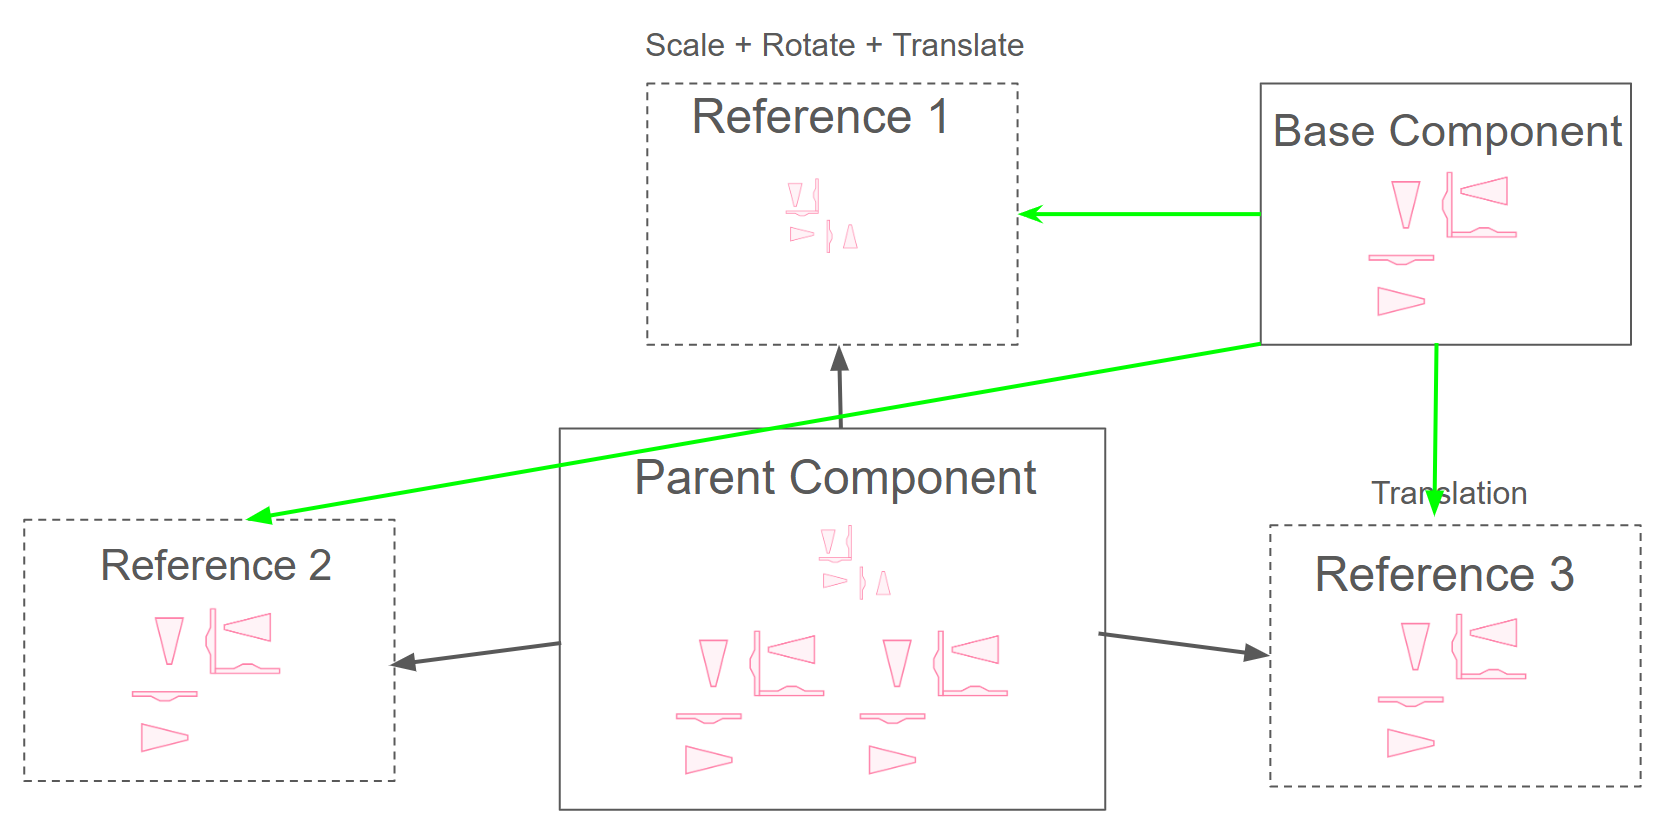


PhotonForge defines your geometry once in a `Component` and reuses it via lightweight `Reference` objects. A `Reference` only stores:

- A pointer to the original component’s geometry
- A transformation (translation, rotation, mirror, scaling)

It does **not** store its own ports. Instead, it dynamically accesses the ports of the original component and applies the transformation. Any updates to the original component’s ports are automatically reflected in the reference.

This is highly memory‐efficient: you can instantiate a large component many times without duplicating its geometry. Ports on the original component are automatically available on each reference, making later connectivity trivial.


In [1]:
import photonforge as pf
import siepic_forge as siepic

# Set the default technology for this project from the PDK library
pf.config.default_technology = siepic.ebeam()

We start by creating an arbitrary polygon component.

In [2]:
# Create a blank Component
parent = pf.Component()

# Create and add a polygon to layer (1, 0)
x_points = [0, 0, 1, 2, 4, 5, 6, 6]
y_points = [0, 0.5, 0.5, 3, 3, 0.5, 0.5, 0]
polygon = pf.Polygon(list(zip(x_points, y_points)))
parent.add((1, 0), polygon)

# View the component
parent

Now, we want to reuse the polygon without creating multiple copies of it. To do this, we create a second blank `Component` called `reuse_demo` and instantiate the original component `parent` inside it. Each `Reference` points back to the same underlying geometry and transformation.


In [3]:
# Create a new blank component
reuse_demo = pf.Component("reuse_demo")

# Instantiate the component "parent" (which holds our polygon)
parent_ref = reuse_demo.add_reference(parent)

# View the single instance
reuse_demo

You can add multiple references to the same underlying component. Each reference can be independently translated, rotated, or mirrored without affecting the original geometry.


In [4]:
# Add two additional references to the component `parent`
parent_ref2 = reuse_demo.add_reference(parent)
parent_ref3 = reuse_demo.add_reference(parent)

# Translate and rotate the second reference
parent_ref2.translate((-2, 0)).rotate(180)

# Rotate and translate the third reference
parent_ref3.rotate(90).translate((-5, 1))

# View the resulting layout with multiple transformed references
reuse_demo

## Updating a Referenced Component

In PhotonForge, references are live links to the original geometry. This means that if you change the contents of a component, any other component that references it will automatically reflect those changes.

To illustrate this behavior, we'll add a second polygon to our base component `parent`. You’ll see that all existing references to `parent` inside `reuse_demo` are instantly updated to include the new shape.


In [5]:
# Define coordinates for the second polygon
x_points_2 = [1, 1, 6, 6]
y_points_2 = [4.75, 5.25, 6.5, 3.5]

# Create the second polygon from the coordinates
polygon2 = pf.Polygon(list(zip(x_points_2, y_points_2)))

# Add the second polygon to the original component `parent`
parent.add((1, 0), polygon2)

# View the updated component
parent

Now let’s check what happened to `reuse_demo`, which contains three references to `parent`.

We haven’t modified `reuse_demo` directly or re-added any references. But because `parent` was updated, and all references inside `reuse_demo` point to `parent`, the layout is automatically updated to reflect the new geometry.


In [6]:
reuse_demo


You can also create references to components that already contain references themselves—this allows you to build hierarchical layouts efficiently. Each reference remains lightweight, even across multiple levels of instantiation.

In this example, we create a new component `hierarchical_layout` that holds three references to the previously defined component `reuse_demo`, which itself contains references to `parent`.

We also demonstrate two ways of adding references:

- Using the `add_reference()` method (as in the previous examples)  
- Using the `Reference()` constructor followed by `add()`

Additionally, we apply a **scaling transformation** to one of the references. This allows you to shrink or enlarge the geometry uniformly while preserving its structure.



In [7]:
# Create a new blank Component
hierarchical_layout = pf.Component()

# Create references to the Component "reuse_demo", which contains multiple references
reuse_ref1 = pf.Reference(reuse_demo)
reuse_ref2 = pf.Reference(reuse_demo)
reuse_ref3 = pf.Reference(reuse_demo)

# Apply scaling, translation, and rotation transformations
reuse_ref1.scale(0.5).translate((15, 10)).rotate(90)
reuse_ref2.translate((-20, 0))

# Add the references to the new hierarchical component
hierarchical_layout.add(reuse_ref1, reuse_ref2, reuse_ref3)

# View the final component
hierarchical_layout

## Ports

To enable connectivity and simulation, each component should define its ports. Ports serve two purposes:

- **Layout connectivity**: they allow components to snap together precisely via `connect()`.  
- **Modeling**: simulation tools like Tidy3D or circuit solvers use ports to define excitation and measurement points.

Here, we manually add a port from the SiEPIC PDK (our default technology in this notebook) to our base component `parent`. The port is placed at `(6, 5)` and points to the left (180°), with a mode specification for multimode TE polarization (already defined in the default technology).


In [8]:
# Define and add a port at the top-right corner of the polygon
port0 = pf.Port(
    center=(6, 5),
    input_direction=180,  # pointing left
    spec="MM_TE_1550_3000",  # multimode TE port spec
)
parent.add_port(port0, "P0")

# View the updated component with the new port
parent

PhotonForge provides built-in utilities to automatically detect ports based on known waveguide specifications. This is useful when working with standard building blocks, such as tapers, waveguides, or gratings, that conform to a known port spec.

Here, we detect and add ports on the component `parent` using the `detect_ports()` method. This is often more convenient and scalable than defining ports manually.


In [9]:
# Automatically detect ports matching the specified waveguide type
parent.add_port(parent.detect_ports(["TE_1550_500"]))

# Display the component with the detected ports
parent

You can get the dictionary of ports.

In [10]:
from rich.pretty import Pretty

Pretty(parent.ports)

{
    'P3': Port(center=(6, 0.25), input_direction=180, spec=PortSpec(description="Strip TE 1550 nm, w=500 nm", 
width=2, limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=3.5, default_radius=0, 
path_profiles=[(0.5, 0, (1, 0))]), extended=True, inverted=False, bend_radius=0),
    'P2': Port(center=(1, 5), input_direction=0, spec=PortSpec(description="Strip TE 1550 nm, w=500 nm", width=2, 
limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=3.5, default_radius=0, 
path_profiles=[(0.5, 0, (1, 0))]), extended=True, inverted=False, bend_radius=0),
    'P1': Port(center=(0, 0.25), input_direction=0, spec=PortSpec(description="Strip TE 1550 nm, w=500 nm", 
width=2, limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=3.5, default_radius=0, 
path_profiles=[(0.5, 0, (1, 0))]), extended=True, inverted=False, bend_radius=0),
    'P0': Port(center=(6, 5), input_direction=180, spec=PortSpec(description="Multimode Strip TE 1550 nm, w=3000 
nm", width=6, limits=(-2, 2.22), num_modes=17, added_solver_modes=0, polarization="", target_neff=3.5, 
default_radius=0, path_profiles=[(3, 0, (1, 0))]), extended=True, inverted=False, bend_radius=0)
}

### Naming Conventions

PhotonForge automatically assigns default port names based on geometric layout and orientation. However, you can assign custom names using the [add_port](../_autosummary/photonforge.Component.rst#photonforge.Component.add_port) method to assign custom identifiers that suit your circuit or documentation needs.


- **Optical ports** use the prefix `P` (e.g., `P0`, `P1`, …)
- **Electrical ports** use the prefix `E`  
- Ports are typically numbered **left to right**, and **bottom to top** if arranged in multiple rows

Here’s a typical 8-port layout with default naming:




          P3   P5
          _|___|_
     P1 -|       |- P7
         |       |
     P0 -|_______|- P6
           |   |
          P2   P4


Port specifications are defined in [PortSpec](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.classification). You can also use the ports already defined in the technology, such as `"TE_1550_500"` for standard strip waveguides in SiEPIC PDK.

Below, we create an 8 port component and then detect and assign ports using the technology-defined waveguide specification.


In [11]:
# Create a new top-level component representing an 8-port device
eight_port_device = pf.Component("8 port device")

# Define a central square block
central_block = pf.Rectangle(center=(0, 0), size=(4, 4))

# Create a waveguide subcomponent with a single horizontal rectangle
waveguide_unit = pf.Component("Waveguide")
waveguide_unit.add((1, 0), pf.Rectangle(center=(-4, -1.5), size=(4, 0.5)))

# Create a 2×2 array of the waveguide spaced 8 µm horizontally and 3 µm vertically
horizontal_array = pf.Reference(
    component=waveguide_unit, columns=2, rows=2, spacing=(8, 3)
)

# Create a second 2×2 waveguide array, rotated 90° for vertical orientation
vertical_array = pf.Reference(
    component=waveguide_unit, origin=(0, 3), columns=2, rows=2, spacing=(3, 8)
).rotate(90)

# Combine the central block and the two waveguide arrays using boolean union
# Place the result on the "Si" layer
eight_port_device.add(
    "Si", *pf.boolean(central_block, [horizontal_array, vertical_array], "+")
)

# Automatically detect and add ports based on the TE_1550_500 waveguide specification
eight_port_device.add_port(eight_port_device.detect_ports(["TE_1550_500"]))

# Return the final component
eight_port_device

You can also assign custom names with a specific ordering convention. For example, using prefix `O` and labeling ports in **clockwise** order starting from the bottom‐left port yields:



          O2   O3
          _|___|_
     O1 -|       |- O4
         |       |
     O0 -|_______|- O5
           |   |
          O6   O7


In [12]:
# Remove any existing ports
for port in eight_port_device.ports:
    eight_port_device.remove_port(port)

# Detect new ports
detected_ports = eight_port_device.detect_ports(["TE_1550_500"])


# Define clockwise sorting function
def clockwise_sort_key(port: pf.Port) -> tuple[int, float]:
    # Determine which side the port is on based on input direction
    # 0 = left (input ~180°), 1 = top (input ~90°), 2 = right (input ~0°), 3 = bottom (input ~270°)
    angle_index = int((45 - port.input_direction) % 360) // 90

    # Use y for left/right ports, x for top/bottom
    coordinate = port.center[1 - angle_index % 2]
    sort_coordinate = coordinate if angle_index < 2 else -coordinate

    return (angle_index, sort_coordinate)


# Sort ports using the clockwise rule
sorted_ports = sorted(detected_ports, key=clockwise_sort_key)

# Add ports with labels O0, O1, ..., in clockwise order
eight_port_device.add_port(sorted_ports, "O")

# Display the updated component with sorted ports
eight_port_device

## Adding Pins

In PhotonForge, you can use [Labels](../_autosummary/photonforge.Label.rst) to annotate port locations — effectively visualizing **pin labels**. This is particularly helpful for documentation, debugging, or generating schematic-style layouts.

In the example below:
- We place a `Label` at each port center with its name as the label text.
- Then we **remove the ports** to avoid clutter or overlap in the layout view (optional, purely for visualization).

This is useful when you want to show where the connections (pins) are, without retaining the functional ports.


In [13]:
# Add a label at each port center using the port's name, then remove the port
for name in eight_port_device.ports:
    port = eight_port_device.ports[name]
    eight_port_device.add(pf.Label(text=name, origin=port.center))
    eight_port_device.remove_port(name)

# Show the layout with only pin labels
eight_port_device

## Arrays of Instances

In PhotonForge, you can efficiently replicate a component in a grid layout by creating a **reference array**. This avoids duplicating geometry while enabling large, repetitive structures like photonic crystals, grating arrays, or heater pads.

The `Reference` object supports placing a component in an **N×M array**, where:
- `columns` is the number of horizontal instances,
- `rows` is the number of vertical instances,
- `spacing` defines the horizontal and vertical pitch in microns.

Below, we create a basic rectangular subcomponent and tile it in a 5×3 array using `pf.Reference`.


In [14]:
# Create a new blank top-level component
array_example = pf.Component("array_example")

# Create a rectangular subcomponent
rectangle_unit = pf.Component("rectangle")
rectangle = pf.Rectangle((0, 0), (2, 1))  # lower-left (0,0), upper-right (2,1)
rectangle_unit.add((1, 0), rectangle)  # add rectangle on layer (1,0)

# Create a 5×3 array of this rectangle with 3 µm horizontal and 4 µm vertical spacing
rectangle_array = pf.Reference(
    component=rectangle_unit,
    origin=(3, 0),  # bottom-left position of array
    columns=5,  # number of columns
    rows=3,  # number of rows
    spacing=(3, 4),  # spacing between instances (x=3µm, y=4µm)
)

# Add the array of rectangles to the top-level component
array_example.add((1, 0), rectangle_array)

# View the final component with the array
array_example

You can also create an array of references for periodic structures.  
This example demonstrates how to define a single period of a nanobeam photonic crystal (PhC) by using boolean subtraction. A circular hole is etched from a rectangular waveguide section to form the photonic crystal unit cell.

We use the `min_evals` argument from [Circle](../_autosummary/photonforge.Circle.rst) to override the automatic value that would be calculated based on the current [tolerance](../config.rst#photonforge.config.tolerance).

In [15]:
def nanobeam_phc_period(period_pitch=1.0, width=0.5, hole_radius=0.2):
    """
    Create one period of a nanobeam photonic crystal using boolean subtraction.

    Parameters:
        period_pitch (float): Lattice period in microns — the horizontal pitch of the unit cell.
        width (float): Width of the waveguide section in microns.
        hole_radius (float): Radius of the circular hole (etched region) in microns.

    Returns:
        pf.Component: A component containing the geometry of one
        nanobeam PhC unit cell, with the hole subtracted from the waveguide core.
    """
    unit_cell = pf.Component("Nanobeam Period")

    # Define the waveguide rectangle centered at origin
    rectangle = pf.Rectangle(
        corner1=(-period_pitch / 2, -width / 2), corner2=(period_pitch / 2, width / 2)
    )

    # Define the circular hole centered in the rectangle
    circle = pf.Circle(radius=hole_radius, center=(0, 0), min_evals=32)

    # Subtract the circle from the rectangle to form a PhC unit cell
    unit_cell.add((1, 0), *pf.boolean(rectangle, circle, operation="-"))

    return unit_cell


# Instantiate one period of the nanobeam PhC
phc_unit = nanobeam_phc_period()

# Visualize the unit cell
phc_unit


To build a full nanobeam photonic crystal structure, we replicate the unit cell using a `Reference` array.  
In this example, we tile the unit cell 10 times along the x-direction to form a periodic nanobeam waveguide.


In [16]:
# Create a new top-level component to hold the nanobeam structure
nanobeam_waveguide = pf.Component("Nanobeam Waveguide")

# Create a 1×10 array of the nanobeam unit cell, spaced 1 µm apart
nanobeam_array = pf.Reference(
    component=phc_unit, columns=10, rows=1, spacing=(1.0, 0.0)
)

# Add the nanobeam array to the waveguide component on layer (1, 0)
nanobeam_waveguide.add((1, 0), nanobeam_array)

To enable optical simulation or circuit-level connectivity, the component must expose ports and models. With both in place, the nanobeam structure can be used in larger circuits or simulated directly.


In [17]:
# Detect and add ports based on the TE_1550_500 waveguide specification
nanobeam_waveguide.add_port(nanobeam_waveguide.detect_ports(["TE_1550_500"]))

# Attach a default Tidy3D model for simulation
nanobeam_waveguide.add_model(pf.Tidy3DModel())

# Export the layout to GDS
nanobeam_waveguide.write_gds()

## Accessing the Referenced Component from an Instance

Each `Reference` in PhotonForge retains a link to its original component.  
This allows you to query information about the referenced geometry, such as its name, ports, or layout bounds.

Here, we print the name of the component that the `nanobeam_array` reference points to.


In [18]:
print(nanobeam_array.component_name)

Nanobeam Period


## Accessing Components from a Layout File

PhotonForge allows you to load a GDS layout and retrieve any subcomponent by name.  
This is useful for inspection, modification, or reuse of specific parts of a design after loading it from disk.

Here, we load the layout file and access the nanobeam unit cell that was referenced inside `nanobeam_waveguide` using its name.


In [19]:
# Load the GDS layout from file
gds_data = pf.load_layout("Nanobeam Waveguide.gds")

# Retrieve the original nanobeam unit cell component by name
nanobeam_loaded = gds_data[nanobeam_array.component_name]

# Confirm the object type and display it
print(type(nanobeam_loaded))
nanobeam_loaded

<class 'photonforge.Component'>


## Adding a Bounding Box

A **bounding box** (or envelope) is the smallest axis-aligned rectangle that fully encloses a given geometry. Bounding boxes are useful for:

- Determining layout extents  
- Creating alignment guides  
- Automating spacing or placing other elements relative to text or shapes  

In this example, we:

1. Create a reusable text component via the [stencil](../stencil.rst) API.  
2. Generate its bounding box using `pf.envelope(..., use_box=True)`.  
3. Add the bounding box to the parent component on a separate layer.


In [20]:
from photonforge.stencil import as_component

# Create a blank parent component
text_with_bbox = pf.Component("text with bbox")

# Create a reusable text component via the stencil API
text_label = as_component(
    stencil="text",
    layer=(10, 0),
    text_string="PhotonForge",
    size=1.0,  # text height in microns
)

# Add the text component as a reference into the parent
text_with_bbox.add_reference(text_label)

# Compute the bounding box (axis-aligned) around the text
bbox = pf.envelope(text_label, use_box=True)

# Add the bounding box on layer (99, 0) for visualization
text_with_bbox.add((99, 0), bbox)

# View the result: text plus its bounding box
text_with_bbox


In some situations, you may want to create a bounding box that **extends slightly beyond** the geometry for padding, clearance, or mask generation.  
This is often useful in:

- Defining keep-out zones  
- Reserving space for packaging or labels  
- Aligning components with spacing buffers

In this example, we create a bounding box around a text component with a **0.5 µm offset**, and visualize it on a separate layer.


In [21]:
# Create a blank parent component
text_with_padded_bbox = pf.Component("text with bbox")

# Add the text component reference
text_with_padded_bbox.add_reference(text_label)

# Compute a bounding box with 0.5 µm padding
padded_bbox = pf.envelope(text_label, offset=0.5, use_box=True)

# Add the bounding box on layer (99, 0) for visual distinction
text_with_padded_bbox.add((99, 0), padded_bbox)

# Display the result
text_with_padded_bbox